# FixMatch

Requires : 
pytorch 1.3.1
torchvision 0.4.2
numpy 1.18.1
matplotlib 3.1.3
pillow 6.2.1

In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os

# Custom packages
import augmentations

In [2]:
print("pytorch",torch.__version__)
print("cuda", torch.version.cuda)
print("cudnn", torch.backends.cudnn.version())
torch.cuda.is_available()


pytorch 1.3.1
cuda 10.0.130
cudnn 7605


True

Replicating the FixMatch algorithm. A wide ResNet will be trained through semi-supervised learning.


## Set-up datasets and transforms
We prepare a CIFAR 250 dataset with:
- a labeled train set with 250 labeled images (the 25 first images of each class)
- a crossvalidation set with 2000 labeled images (200 per class)
- an unlabeled train set with 47750 images, which had their label dropped

### Load data

In [3]:
cifar_train = datasets.CIFAR10(
    root='./cifar_data/', train=True, transform=None, download=True)
cifar_test = datasets.CIFAR10(
    root='./cifar_data/', train=False, transform=transforms.ToTensor(), download=True)

# Split into balanced datasest
ind_labeled = np.zeros((250,),dtype=int)
ind_cross = np.zeros((2000,),dtype=int)
ind_unlabeled = np.zeros((47750,),dtype=int)

tgt = np.array(cifar_train.targets)
for ii in range(10):
    indices, = np.where(tgt==ii)
    ind_labeled[ii*25:(ii+1)*25] = indices[:25]
    ind_cross[ii*200:(ii+1)*200] = indices[25:225]
    ind_unlabeled[ii*4775:(ii+1)*4775] = indices[225:]

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Adapted from:
# https://discuss.pytorch.org/t/apply-different-transform-data-augmentation-to-train-and-validation/63580/2


class MapDataset(torch.utils.data.Dataset):
    """
    Given a dataset, creates a dataset which applies a mapping function
    to its items (lazily, only when an item is called).

    Note that data is not cloned/copied from the initial dataset.
    """
    def __init__(self, dataset, map_func):
        self.dataset = dataset
        self.map_func = map_func
    
    def mapping(self,d):
        return self.map_func(d)
    
    def __getitem__(self, index):
        return self.mapping(self.dataset[index])

    def __len__(self):
        return len(self.dataset)


class LabeledAugment(MapDataset):
    """
    Given a labeled dataset, applies the transform to the image only
    """
    def mapping(self, d):
        img, y = d
        return self.map_func(img), y

class UnabeledAugment(MapDataset):
    """
    Given a labeled dataset, drops the label and applies a weak and strong transform to the image
    """
    def __init__(self, dataset, map_func_weak, map_func_strong):
        super(UnabeledAugment, self).__init__(dataset,map_func_weak)
        self.map_func_strong = map_func_strong

    def __getitem__(self, index):
        img, y = self.dataset[index]
        return self.map_func(img), self.map_func_strong(img)

### Set-up transforms
In order to implement the FixMatch alorithm, we need to set-up a weak and a strong augmentation.

#### Weak augmentation
The weak augmentation only consists in 


In [5]:
# Compute the average color on the train set (labels not used)
"""average_color = torch.zeros(3, dtype=torch.float32)
for x, _ in cifar_train:
    average_color += TF.to_tensor(x).mean(axis=(1, 2))
average_color /= len(cifar_train)
average_color_PIL = tuple((average_color.numpy()*255).astype(np.uint8))
"""
average_color = torch.tensor([0.4914, 0.4822, 0.4465])
average_color_PIL = tuple(np.uint8(rgb) for rgb in [125,122,113])

In [6]:
weak_augment_transform = \
    transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(0, translate=(1/8,1/8),
                                fillcolor=average_color_PIL),
        transforms.ToTensor()
        ])

cifar_labeled = LabeledAugment(Subset(cifar_train, ind_labeled), weak_augment_transform)
cifar_crossval = LabeledAugment(Subset(cifar_train, ind_cross), transforms.ToTensor())


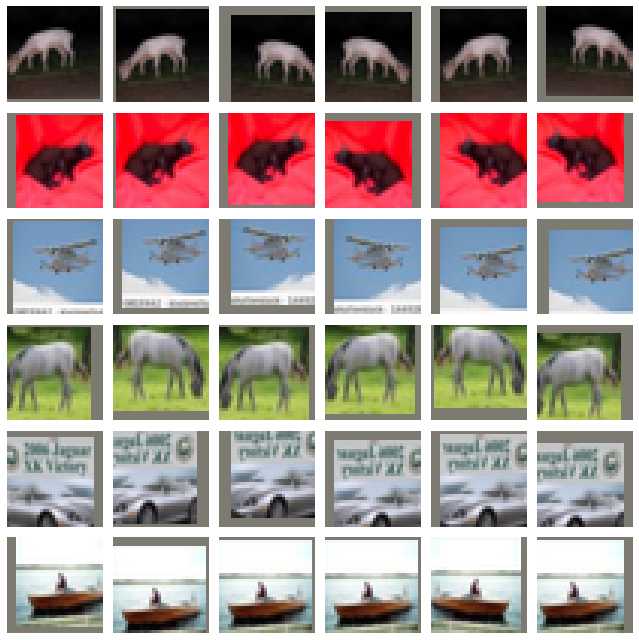

In [7]:
f, axs = plt.subplots(6,6, figsize=(9,9))
for axline in axs:
    ii = np.random.choice(250)
    for ax in axline:
        x, _ = cifar_labeled[ii]
        ax.imshow(np.moveaxis(x.numpy(),0,2))
        ax.set_axis_off()
f.tight_layout();

#### Strong augmentations
The strong augmentation pipeline contains:
- Cutout
- RandAugment: random augmentation among 14 available PIL transforms (plus a 15th one, Hue shift added because why not?)

Cutout consists in erasing a 16x16 pixel area centered on a random pixels of the image. Each channel is replaced by teh average across the training set so that batch statistics should not be affected by the transform.

RandAugment consists in N successive application transforms sampled from the following list:


| **Operation**    | Description                                                 | Range          |
|------------------|-------------------------------------------------------------|----------------|
| **Autocontrast** | Maximizes the image contrast by setting the darkest (lightest) pixel to black (white). | |
| **Brightness**   | Adjusts the brightness of the image. B = 0 returns a black  image, B = 1 returns the original image. | B [0.05, 0.95] |
| **Color**        | Adjusts the color balance of the image like in a TV.C = 0 returns a black & white image, C = 1 returns the original image. | C [0.05, 0.95] |
| **Contrast**     | Controls the contrast of the image. A C = 0 returns a gray  image, C = 1 returns the original image. | C [0.05, 0.95] | 
| **Equalize**     | Equalizes the image histogram.                              |                |
| **Identity**     | Returns the original image.                                 |                |
| **Posterize**    | Reduces each pixel to B bits.                               | B [4, 8]       |
| **Rotate**       | Rotates the image by θ degrees.                             | θ [-30, 30]    |
| **Sharpness**    | Adjusts the sharpness of the image, where S = 0 returns a blurred image, and S = 1 returns the original image. | S [0.05, 0.95] |
| **Shear x**      | Shears the image along the horizontal axis with rate R.     | R [-0.3, 0.3]  |
| **Shear y**      | Shears the image along the vertical axis with rate R.       | R [-0.3, 0.3]  |
| **Solarize**     | Inverts all pixels above a threshold value of T.            | T [0, 1]       |
| **Translate x**  | Translates the image horizontally by (λ×image width) pixels.| λ [-0.3, 0.3]  |
| **Translate y**  | Translates the image vertically by (λ×image height) pixels. | λ [-0.3, 0.3]  |
| ***Hue shift***  | *Shifts the hue of the image (H channel in the HSV space)*  | H [-0.2, 0.2]  |

In [8]:
N_RAND_AUGMENT = [2]

strong_augment_transform = \
    transforms.Compose([
        augmentations.Cutout(
            patch_size=16,
            default_color=average_color_PIL,
            input_type="image",
            channel_drop_proba=1.0,
            inplace=True
        ),
        augmentations.RandAugment(N_RAND_AUGMENT),
        transforms.ToTensor()
    ])

cifar_unlabeled = UnabeledAugment(Subset(cifar_train, ind_unlabeled),
                                weak_augment_transform,
                                strong_augment_transform)

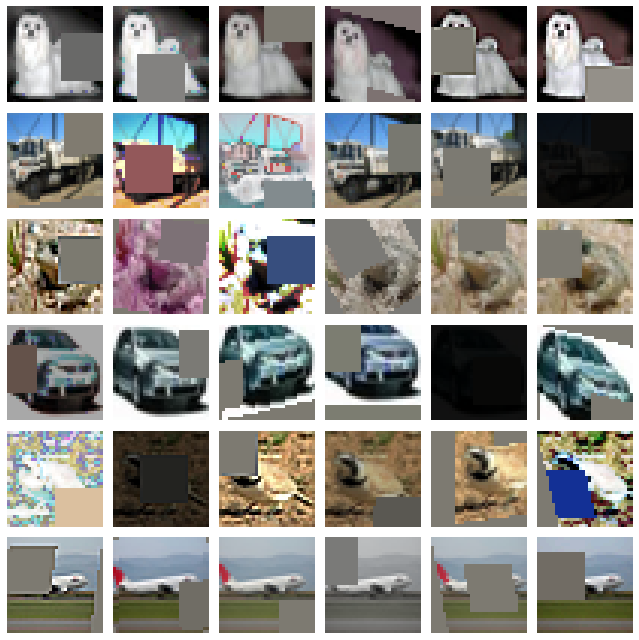

In [9]:
f, axs = plt.subplots(6,6, figsize=(9,9))
for axline in axs:
    ii = np.random.choice(47750)
    for ax in axline:
        _, img = cifar_unlabeled[ii]
        ax.imshow(np.moveaxis(img.numpy(),0,2))
        ax.set_axis_off()
f.tight_layout();

### Dataloaders
Several dataloaders are prepared:
- one labeled train loader that produces batches of weakly augmented images with their ground-truth label
- one unlabeled train loader that produces pairs of weak and strong augmentations for images
- three unaugmented dataloaders to measure loss ad accuracy on the the labeled train, cross-validation and test datasets

In [10]:
class ContinuousSampler(torch.utils.data.Sampler):
    """
    Iterator to provide random indices from the supervised train set
    The iterator never stops, do not call alone!
    """

    def __init__(self, dataset_length, batch_size):
        self.dataset_length = dataset_length
        self.batch_size = batch_size
        self._buffer = []

    def __iter__(self):
        return self

    def _buffer_check(self):
        if not self._buffer:
            self._buffer = list(np.random.choice(
                                self.dataset_length,
                                self.batch_size,
                                replace=False))

    def __next__(self):
        self._buffer_check()
        return self._buffer.pop()

In [11]:
MU = 7
BATCH_SIZE = 64

labeled_sampler = torch.utils.data.RandomSampler(data_source=cifar_labeled,
                                                 replacement=True,
                                                 num_samples=BATCH_SIZE)

train_loader_labeled = DataLoader(
                        dataset=cifar_labeled,
                        sampler = ContinuousSampler(len(cifar_labeled), BATCH_SIZE),
                        batch_size= BATCH_SIZE,
                        pin_memory= True,
                        num_workers = 2)
train_loader_unlabeled = DataLoader(
                        dataset=cifar_unlabeled,
                        shuffle=True,
                        batch_size= BATCH_SIZE,
                        pin_memory= True,
                        num_workers = 10)
crossval_loader = DataLoader(
                    dataset=cifar_crossval,
                    shuffle=False,
                    batch_size= BATCH_SIZE,
                    pin_memory= True,
                    num_workers = 2)
test_loader = DataLoader(cifar_test, shuffle=False, batch_size=BATCH_SIZE)

### Training sequence

UDA and FixMatch have much in common. Batches are split into smaller sub-batches that are preocessed one by one. The gradient is accumulated and a descent step taken after the last sub-batch. This limits the memory usage (own GPU has 4GB).

In [12]:
PSEUDO_LABEL_PROBA_THRESHOLD = 0.95
VERBOSITY = 2
MU = 7


def train_one_epoch(model, optimizer, labeled_set, unlabeled_set,
                    lambd=1.0, display_interval=250, mu=MU):
    t0 = time.time()
    batch_idx = 0

    accu_thres, running_thres = 0, 0
    accu_ls, accu_lu = 0., 0.
    running_ls, running_lu = 0., 0.
    labeled_sampler = iter(labeled_set)
    optimizer.zero_grad()

    for y_weak, y_strong in unlabeled_set:
        batch_idx += 1
        # Set Network in evaluation mode and compute pseudo-labels
        model.train(False)
        with torch.no_grad():
            y_weak = y_weak.cuda()
            logits_weak = F.softmax(model(y_weak), dim=1)
            pseudo_labels = logits_weak.argmax(dim=1).detach()
            max_values = torch.gather(
                logits_weak, 1, pseudo_labels.view(-1, 1)).view(-1)
            valid_indices, = torch.nonzero(
                max_values > PSEUDO_LABEL_PROBA_THRESHOLD,
                as_tuple=True)
            del logits_weak

        model.train(True)

        optimizer.zero_grad()
        predict_strong = model(y_strong.cuda())
        if valid_indices.numel():
            loss_unsupervised = F.cross_entropy(
                predict_strong,
                pseudo_labels,
                reduction='none')
            loss_unsupervised = loss_unsupervised.index_select(
                0, valid_indices).sum()
            loss_unsupervised *= lambd/BATCH_SIZE
            loss_unsupervised.backward()

            accu_lu += loss_unsupervised.item()
            running_lu += loss_unsupervised.item()
            accu_thres += valid_indices.numel()
            running_thres += valid_indices.numel()
        optimizer.step()

        if mu is not None and batch_idx % mu == 0:
            optimizer.zero_grad()
            x, label = next(labeled_sampler)
            loss_supervised = F.cross_entropy(model(x.cuda()),
                                              label.cuda(),
                                              reduction='mean')
            loss_supervised.backward()

            optimizer.step()
            optimizer.zero_grad()

            accu_ls += loss_supervised.item()
            running_ls += loss_supervised.item()
            optimizer.step()

        if VERBOSITY >= 2 and batch_idx % display_interval == 0:
            running_ls /= (display_interval//mu)
            if running_thres:
                running_lu /= (running_thres/BATCH_SIZE)
            running_thres /= (display_interval * BATCH_SIZE)
            print(("==> batch {i}/{n}: supervised_loss {ls:.3f}, " +
                   "unsupervised_loss {lu:.3f}, above threshold {thr:.1f}%").format(
                i=batch_idx, n=len(unlabeled_set),
                ls=running_ls, lu=running_lu,
                thr=100*running_thres))
            running_ls, running_lu, running_thres = 0., 0., 0

    if VERBOSITY >= 1:
        print(("Epoch done in {t:.0f}s, cumulative loss: {l:.0f}, " +
               "above_threshold: {thr:.1f}").format(
            t=time.time()-t0, l=accu_ls + accu_lu,
            thr=accu_thres/len(unlabeled_set.dataset)))

In [13]:
def test_net(model, dataloader):
    model.train(False)
    n_in_dataset = len(dataloader.dataset)
    
    cumul_loss = 0.0
    class_ok = 0
    with torch.no_grad():
        for batch_idx, (x, gt) in enumerate(dataloader):
            x, gt = x.cuda(), gt.cuda()
            output = model(x)
            cumul_loss += F.cross_entropy(output, gt).item()
            predicted_class = output.argmax(dim=1)
            class_ok += (predicted_class == gt).sum()

    avg_loss = cumul_loss /(batch_idx+1)
    accuracy = float(class_ok) / n_in_dataset
    print("Well classified %5d / %5d, (%5.2f%% accuracy)" % (
        class_ok, n_in_dataset, 100*accuracy))
    print("Average loss : %f" % cumul_loss)
    return avg_loss, accuracy

In [14]:
float((torch.tensor([1,2,3])==torch.tensor([1,3,3])).sum())


2.0

In [15]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.randint(5, (3,), dtype=torch.int64)
loss = F.cross_entropy(input, target, reduction="none")
loss3 = F.cross_entropy(input, target, reduction="sum")

## Network


In [16]:
from layers import WideResnetBlock

In [26]:
torch.cuda.memory_allocated()

99735040

In [18]:
WRN_K = 4
BASE_SIZE = 64
INPUT_CHANNELS = 3
N_CLASSES = 10
CLASSIFIER_WIDTH = 512

model = nn.Sequential(
    nn.BatchNorm2d(INPUT_CHANNELS),
    nn.Conv2d(INPUT_CHANNELS, BASE_SIZE, (3, 3), bias=True, padding=1),
    # 32x32
    WideResnetBlock(BASE_SIZE,WRN_K, groups=4),
#    WideResnetBlock(BASE_SIZE,WRN_K),
    WideResnetBlock(BASE_SIZE,WRN_K, groups=4,"concatenate"),
    nn.MaxPool2d(2, stride=2),
    # 16x16
    WideResnetBlock(2*BASE_SIZE,WRN_K, groups=4),
#    WideResnetBlock(2*BASE_SIZE,WRN_K),
    WideResnetBlock(2*BASE_SIZE,WRN_K, groups=4,"concatenate"),
    nn.MaxPool2d(2, stride=2),
    # 8x8
    WideResnetBlock(4*BASE_SIZE,WRN_K, groups=4),
#    WideResnetBlock(4*BASE_SIZE,WRN_K),
    WideResnetBlock(4*BASE_SIZE,WRN_K, groups=4,"concatenate"),
    # Classifier
    nn.BatchNorm2d(8*BASE_SIZE),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(output_size=(1, 1)),
    nn.Flatten(),
    nn.Dropout(.3),
    nn.Linear(8*BASE_SIZE,CLASSIFIER_WIDTH),
    nn.BatchNorm1d(CLASSIFIER_WIDTH),
    nn.ReLU(),
    nn.Linear(CLASSIFIER_WIDTH,N_CLASSES)
    ).cuda()

#optimizer = optim.Adam(net01.parameters(), lr=LEARNING_RATE)

In [19]:
pytorch_training_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_training_params)

8022032


In [28]:
torch.cuda.memory_allocated()

99735040

In [21]:
torch.cuda.empty_cache()

## Train the network!


In [22]:
TEST_ID = 1

LR_INIT = 0.003
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
N_EPOCH = 50
MU = 10
LAMBDA = .5

optimizer = torch.optim.SGD(model.parameters(), lr=LR_INIT, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

def lr_schedule(epoch, warmup = 5):
    lr = np.cos(7/16*np.pi*epoch/N_EPOCH)
    if epoch+1 < warmup:
        lr *= (epoch+1)/warmup
    return lr*LR_INIT

In [23]:
best_acc = 0
for epoch in range(N_EPOCH):
    print("=== Epoch %d ===" % epoch)
    train_one_epoch(model, optimizer, train_loader_labeled, train_loader_unlabeled,
                    display_interval=100, mu=MU, lambd=LAMBDA)
    _, acc = test_net(model, crossval_loader)
    if acc > best_acc:
        torch.save(model.state_dict(),
               "ssl-cifar-250-v%02d_e%02d.torchmodel" % (TEST_ID, epoch))
        best_acc = acc
    # Cosine schedule
    new_lr = lr_schedule(epoch)
    for p in optimizer.param_groups:
        p['lr'] = new_lr

=== Epoch 0 ===
==> batch 100/747: supervised_loss 2.045, unsupervised_loss 0.000, above threshold 0.0%
==> batch 200/747: supervised_loss 1.625, unsupervised_loss 0.630, above threshold 0.1%
==> batch 300/747: supervised_loss 1.417, unsupervised_loss 0.369, above threshold 0.2%
==> batch 400/747: supervised_loss 1.297, unsupervised_loss 0.745, above threshold 2.2%
==> batch 500/747: supervised_loss 1.134, unsupervised_loss 0.548, above threshold 3.5%
==> batch 600/747: supervised_loss 1.063, unsupervised_loss 0.649, above threshold 8.0%
==> batch 700/747: supervised_loss 0.834, unsupervised_loss 0.552, above threshold 7.6%
Epoch done in 184s, cumulative loss: 112, above_threshold: 0.0
Well classified   677 /  2000, (33.85% accuracy)
Average loss : 84.330091
=== Epoch 1 ===
==> batch 100/747: supervised_loss 0.625, unsupervised_loss 0.451, above threshold 10.5%
==> batch 200/747: supervised_loss 0.529, unsupervised_loss 0.458, above threshold 10.5%
==> batch 300/747: supervised_loss 0.

==> batch 600/747: supervised_loss 0.072, unsupervised_loss 0.287, above threshold 41.3%
==> batch 700/747: supervised_loss 0.112, unsupervised_loss 0.315, above threshold 41.3%
Epoch done in 232s, cumulative loss: 100, above_threshold: 0.4
Well classified   923 /  2000, (46.15% accuracy)
Average loss : 76.804482
=== Epoch 11 ===
==> batch 100/747: supervised_loss 0.119, unsupervised_loss 0.317, above threshold 40.9%
==> batch 200/747: supervised_loss 0.058, unsupervised_loss 0.315, above threshold 40.1%
==> batch 300/747: supervised_loss 0.193, unsupervised_loss 0.360, above threshold 46.0%
==> batch 400/747: supervised_loss 0.170, unsupervised_loss 0.348, above threshold 36.2%
==> batch 500/747: supervised_loss 0.055, unsupervised_loss 0.297, above threshold 40.8%
==> batch 600/747: supervised_loss 0.091, unsupervised_loss 0.322, above threshold 42.0%
==> batch 700/747: supervised_loss 0.087, unsupervised_loss 0.269, above threshold 44.2%
Epoch done in 232s, cumulative loss: 107, abo

==> batch 300/747: supervised_loss 0.033, unsupervised_loss 0.214, above threshold 48.5%
==> batch 400/747: supervised_loss 0.049, unsupervised_loss 0.193, above threshold 49.0%
==> batch 500/747: supervised_loss 0.030, unsupervised_loss 0.215, above threshold 52.3%
==> batch 600/747: supervised_loss 0.038, unsupervised_loss 0.210, above threshold 50.7%
==> batch 700/747: supervised_loss 0.037, unsupervised_loss 0.202, above threshold 50.3%
Epoch done in 232s, cumulative loss: 78, above_threshold: 0.5
Well classified  1158 /  2000, (57.90% accuracy)
Average loss : 65.120022
=== Epoch 22 ===
==> batch 100/747: supervised_loss 0.039, unsupervised_loss 0.212, above threshold 53.3%
==> batch 200/747: supervised_loss 0.075, unsupervised_loss 0.245, above threshold 51.6%
==> batch 300/747: supervised_loss 0.030, unsupervised_loss 0.213, above threshold 48.9%
==> batch 400/747: supervised_loss 0.024, unsupervised_loss 0.187, above threshold 52.8%
==> batch 500/747: supervised_loss 0.021, unsu

Epoch done in 232s, cumulative loss: 78, above_threshold: 0.6
Well classified  1269 /  2000, (63.45% accuracy)
Average loss : 61.149476
=== Epoch 32 ===
==> batch 100/747: supervised_loss 0.019, unsupervised_loss 0.165, above threshold 60.8%
==> batch 200/747: supervised_loss 0.025, unsupervised_loss 0.170, above threshold 62.1%
==> batch 300/747: supervised_loss 0.014, unsupervised_loss 0.161, above threshold 56.9%
==> batch 400/747: supervised_loss 0.019, unsupervised_loss 0.172, above threshold 58.1%
==> batch 500/747: supervised_loss 0.017, unsupervised_loss 0.174, above threshold 60.1%
==> batch 600/747: supervised_loss 0.015, unsupervised_loss 0.167, above threshold 60.4%
==> batch 700/747: supervised_loss 0.026, unsupervised_loss 0.175, above threshold 59.8%
Epoch done in 232s, cumulative loss: 77, above_threshold: 0.6
Well classified  1284 /  2000, (64.20% accuracy)
Average loss : 64.081077
=== Epoch 33 ===
==> batch 100/747: supervised_loss 0.013, unsupervised_loss 0.169, abov

==> batch 500/747: supervised_loss 0.008, unsupervised_loss 0.142, above threshold 66.9%
==> batch 600/747: supervised_loss 0.011, unsupervised_loss 0.134, above threshold 67.5%
==> batch 700/747: supervised_loss 0.015, unsupervised_loss 0.144, above threshold 66.6%
Epoch done in 232s, cumulative loss: 71, above_threshold: 0.7
Well classified  1361 /  2000, (68.05% accuracy)
Average loss : 53.235751
=== Epoch 43 ===
==> batch 100/747: supervised_loss 0.012, unsupervised_loss 0.133, above threshold 66.1%
==> batch 200/747: supervised_loss 0.008, unsupervised_loss 0.134, above threshold 66.8%
==> batch 300/747: supervised_loss 0.010, unsupervised_loss 0.149, above threshold 66.8%
==> batch 400/747: supervised_loss 0.008, unsupervised_loss 0.147, above threshold 67.6%
==> batch 500/747: supervised_loss 0.012, unsupervised_loss 0.145, above threshold 66.6%
==> batch 600/747: supervised_loss 0.008, unsupervised_loss 0.139, above threshold 67.2%
==> batch 700/747: supervised_loss 0.008, unsu

In [24]:
torch.save(model.state_dict(), "ssl-cifar-250-v%02d.torchmodel"%TEST_ID)

In [25]:
test_net(model, test_loader)

Well classified  6980 / 10000, (69.80% accuracy)
Average loss : 297.735980


(1.8964075134817961, 0.698)